### Topic: K-Means Clustering - Applications (Image Segmentation)
- Theory and Algo
- Mathematical Background
- Image Segmentation - What is it?
- Image Segmentation - Why do we need it?
- Perform Image Segmentation using K-Means Clustering (Look at Lloyd and Elken Algorithm)
- Explore different values of K
- Metrics used to find the perfect value of K (Variance, KL DIvergence, Correlation, time taken, RGB Histograms)
- Alogrithm to find the perfect value of K (elbow and silhouette method)
- The good and the bad

(Classification if less topics - Fashion MNIST)

- Filter function (Done)
- Histogram function (Done)
- Elbow & Silhouette plots for 5 images with time (Need to run on 5 images; funcs done)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

In [27]:
image = plt.imread('bug_4.jpg')
plt.imshow(image)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'bug_4.jpg'

In [28]:
class ImageSegmentation:

    ''' 
    This class is used to segment an image into k clusters. 
    Specify the number of clusters in the constructor.
    The class has two methods:
    1. fit: This method takes an image as input and segments it into k clusters.
    2. get_segmented_image: This method returns the segmented image.

    Class Variables
    ---------------
    num_clusters: (int) Number of clusters to segment the image into.
    kmeans: (sklearn.cluster.KMeans) KMeans object from sklearn.cluster.
    seg_image: (numpy.ndarray) Segmented image.
    cluster_centers: (numpy.ndarray) Cluster centers of the segmented image.
    colors: (numpy.ndarray) Colors of the segmented image.
    '''
    
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=10)
        self.seg_image = None
        self.cluster_centers = None
        self.colors = np.zeros((num_clusters, 1, 3), dtype=np.uint8)

    def normalize(self, image):
        
        '''
        This function normalizes the image.
        If the image is grayscale, it normalizes the image.
        If the image is RGB, it normalizes each channel of the image.

        Parameters
        ----------
        image: (numpy.ndarray) Image to be normalized.

        Returns
        -------
        Normalized image.
        '''
        if len(image.shape) < 3:
            return (image - np.min(image)) / (np.max(image) - np.min(image))
        
        elif len(image.shape) == 3:
            new = np.zeros(image.shape, dtype=np.float32)
            for k in range(3):
                new[:, :, k] = (image[:, :, k] - np.min(image[:, :, k])) / (np.max(image[:, :, k]) - np.min(image[:, :, k]))

            return new
    
    def fit(self, image):
        
        '''
        This function segments the image by clustering the image pixels into k clusters 
        based on the color intensity values of the pixel.

        Parameters
        ----------
        image: (numpy.ndarray) Image to be segmented.
        '''
        vectorized = np.float32(image.reshape((-1, 3)))
        self.kmeans.fit(vectorized)
        self.seg_image = self.kmeans.predict(vectorized).reshape(image.shape[:2])
        self.cluster_centers = np.array(self.kmeans.cluster_centers_, dtype=np.uint8)
        
        for i in range(self.num_clusters):
            self.colors[i, 0, 0] = self.cluster_centers[i, 0]
            self.colors[i, 0, 1] = self.cluster_centers[i, 1]
            self.colors[i, 0, 2] = self.cluster_centers[i, 2]

    def get_segmented_image(self):
        
        '''
        This function returns the segmented image with applying the colors of the 
        identified cluster centers.

        Returns
        -------
        Segmented image.
        '''
        new_image = np.zeros((self.seg_image.shape[0], self.seg_image.shape[1], 3), dtype=np.uint8)
        for i in range(self.num_clusters):
            new_image[self.seg_image == i, :] = self.colors[i]

        return new_image
    
    def filter(self, image, level = 6, return_img = False):
        
        '''
        Applies a custom filter to the input image that blurs the textures while
        maintaining the edges.
        This also displays the image.

        Parameters
        ----------
        image : (numpy.ndarray) The image to be filtered.
        level : (int, optional) The level of filtering. Lowest - 0, Highest - 10. The default is 6.
        return_img: (boolean, optional) States whether the generated image should be returned

        Returns
        -------
        (numpy.ndarray) The image with the filter applied on it.
        '''
        
        level = np.clip(level, 0, 10)    
        self.fit(image)
        segmented_image = self.get_segmented_image()

        new = np.array(image * (1 - level/10) + segmented_image * (level/10), dtype=np.uint8)

        plt.imshow(new)
        # plt.imsave('processedImage.jpg', new)
        plt.show()

        if return_img:
            return new

    def histogram(self, image, plot_hist=True, return_hist = False):
        
        ''' 
        Generates the histogram for the image. If grayscale image, histogram for a 
        single chanel is generated. If RGB image, histogram for each channel is generated.

        Parameters
        ----------
        image: (numpy.ndarray) The image whose histogram is to be generated
        plot_hist: (boolean, optional) States whether the histograms should be plotted.
                    Default is True
        return_hist: (boolean, optional) States whether a list containing the histogram
                        for the constituent channels should be returned. Default is False.

        Returns
        -------
        out_hist: (list of numpy.ndarray) List containing the histograms of the constituent 
                    channels of the input image.
        '''
       
        out_hist = []
        if len(image.shape) == 2:
            
            if np.max(image) <= 1:
                fin_img = np.array(image*255, dtype = int)
            else:
                fin_img = image
            
            hist = np.zeros(256)
            for i in range(fin_img.shape[0]):
                for j in range(fin_img.shape[1]):
                    hist[int(fin_img[i, j])] += 1
            
            out_hist.append(hist)
        
        elif len(image.shape) == 3:
            
            r_hist = self.histogram(image[:, :, 0], False, True)[0]
            g_hist = self.histogram(image[:, :, 1], False, True)[0]
            b_hist = self.histogram(image[:, :, 2], False, True)[0]

            out_hist.append(r_hist)
            out_hist.append(g_hist)
            out_hist.append(b_hist)

        if plot_hist:
            if len(out_hist) == 2:
                plt.plot([i for i in range(0, 256)], out_hist[0])
            
            if len(out_hist) == 3:
                colors = ['r', 'g', 'b']
                for k in range(3):
                    plt.bar([i for i in range(256)], out_hist[k], width=1, color=colors[k], alpha=0.6, label=colors[k].upper()+' Channel')

            plt.legend()
            plt.grid()
            plt.title('Histogram')
            plt.xlabel('Intensities')
            plt.ylabel('Frequency')
            plt.show()

        if return_hist:
            return out_hist

    def read_image(self, filename):
        arr = np.load(filename)
        w = arr[0]
        h = arr[1]
        temp = arr[2:2+w*h].reshape((w, h))
        cols = arr[2+(w*h):]
        out = np.zeros((w, h, 3))

        for i in range(w):
            for j in range(h):
                out[i, j] = cols[arr[temp[i, j]]]

        return out
    
    def save_image(self, img, filename, quality=7):

        quality = np.clip(quality, 1, 10)
        obj = ImageSegmentation(quality*10)
        obj.fit(img)
        # seg_img = obj.get_segmented_image()
        w, h, _= img.shape
        out_arr = []
        out_arr.append(w)
        out_arr.append(h)
        temp = obj.seg_image.reshape((1, w*h))[0]
        out_arr.extend(temp)
        for col in obj.colors:
            out_arr.append(col[0])

        print(out_arr)                                              

In [29]:
def elbow_plot(image, end=10, return_inertias=False, return_times=False):
    
    ''' 
    Generates the elbow curve for the given image.

    Parameters
    ----------
    image : (numpy.ndarray) The image to be segmented.
    end : (int, optional) The number of clusters to be considered. The default is 10.
    return_inertias : (bool, optional) Whether to return the inertias. The default is False.
    return_times : (bool, optional) Whether to return the times taken. The default is False.

    Returns
    -------
    Inertias and the times taken, if specified.
    '''
    
    inertias = []
    times = []
    
    for i in range(2, end+1):
        
        print('Elbow Method - Running for {} clusters...    '.format(i), end='\r')
        cur_inertia = 0
        cur_time = 0
        imgseg = ImageSegmentation(num_clusters = i)
        
        for j in range(3):
            st = time.time()
            imgseg.fit(image)
            cur_inertia += imgseg.kmeans.inertia_
            cur_time += time.time() - st
        
        inertias.append(cur_inertia / 3)
        times.append(cur_time / 3)
    print('Elbow Method - Completed.' + ' ' * 30)
    out = []
    if return_times:
        out.append(times)

    if return_inertias:
        out.append(inertias)

    if len(out) == 0:
        return
    else:
        return out

In [30]:
def silhouette_plot(image, end=7, return_scores=False, return_times=False):
    
    ''' 
    Generates the silhouette curve for the given image.

    Parameters
    ----------
    image : (numpy.ndarray) The image to be segmented.
    end : (int, optional) The number of clusters to be considered. The default is 7.
    return_scores : (bool, optional) Whether to return the scores. The default is False.
    return_times : (bool, optional) Whether to return the times taken. The default is False.

    Returns
    -------
    Scores and the times taken, if specified.
    '''
    
    X = image.reshape((-1, 3))
    range_n_clusters = [i for i in range(2, end+1)]
    scores = []
    times = []
    for n_clusters in range_n_clusters:
        
        print('Silhouette Method - Running for {} clusters...    '.format(n_clusters), end='\r')
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        separator = len(X) // 50
        ax.set_xlim([-0.3, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 1) * separator])
        local_scores = []
        local_times = []
        for i in range(3):
            st = time.time()
            clusterer = KMeans(n_clusters=n_clusters)
            cluster_labels = clusterer.fit_predict(X)
            local_scores.append(silhouette_score(X, cluster_labels))
            local_times.append(time.time() - st)

        times.append(np.mean(local_times))
        silhouette_avg = np.mean(local_scores)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        # print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
        scores.append(silhouette_avg)

        y_lower = separator
        for i in range(n_clusters):
            
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + separator

        ax.set_title("Silhouette plot for n_clusters = " + str(n_clusters) + ".")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.grid()
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])
        ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    print('Sihouette Method - Completed.' + ' ' * 30)
    plt.show()

    out = []
    if return_times:
        out.append(times)

    if return_scores:
        out.append(scores)

    if len(out) == 0:
        return
    else:
        return out

In [31]:
def optimal_k(image, end=10, times=False):
    
    ''' 
    1. Finds the optimal value of K for the given image.
    2. Prints the optimal value of K and the respective graphs for the elbow and silhouette methods
    and the time graph vs the number of clusters.

    Parameters
    ----------
    image : (numpy.ndarray) The image to be segmented.
    end : (int, optional) The number of clusters to be considered. The default is 10.
    times : (bool, optional) Whether to return the times taken. The default is False.

    Returns
    -------
    None.
    '''
    
    print('Running Elbow Method...', end='\r')
    elbow_out = elbow_plot(image, end, return_inertias=True, return_times=times)
    print('Running Silhouette Method...', end='\r')
    sil_out = silhouette_plot(image, end, return_scores=True, return_times=times)

    if times:
        elbow_times = elbow_out[0]
        sil_times = sil_out[0]
        inertias = elbow_out[1]
        scores = sil_out[1]

    else:
        inertias = elbow_out[0]
        scores = sil_out[0]
    
    print('ANALYSIS')
    print('--------\n')
    print('* Optimal Value of K is', np.argmax(scores)+2, 'with a score of {:5f}'.format(np.max(scores)), 'according to the Silhouette Method.')
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, end+1), inertias, 'ko-', label='Inertia')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertias')
    plt.title('Elbow Plot')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(range(2, end+1), scores, 'ko-', label='Silhouette score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('Silhouette Plot')
    plt.grid()
    plt.legend()
    plt.show()

    if times:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, end+1), elbow_times, 'ko-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Time Taken')
        plt.title('Time for Elbow Method')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(range(2, end+1), sil_times, 'ko-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Time Taken')
        plt.title('Time for Silhouette Method')
        plt.grid()
        plt.show()

In [ ]:
# rerun for image
optimal_k(image, end=7, times=True)

In [ ]:
optimal_k(image, 7, True)

In [ ]:
imgseg = ImageSegmentation(5)
imgseg.fit(image)
seg_img = imgseg.get_segmented_image()

In [ ]:

plt.imshow(image)
plt.show()
imgseg.histogram(image)
plt.imshow(seg_img, cmap='gray', vmax=255, vmin=0)
plt.show()
histo = imgseg.histogram(seg_img, return_hist=True)

In [ ]:
iseg = ImageSegmentation(75)
iseg.fit(image)
out = iseg.get_segmented_image()
plt.imshow(out)
plt.show()

In [ ]:
iseg = ImageSegmentation(5)
iseg.save_image(out, 'out.png', 4)

In [ ]:
bridge = plt.imread('bridge.jpg')
ridge = plt.imread('ridge.jpg')
sunflower = plt.imread('sunflower.jpg')
street = plt.imread('street.jpg')
scene = plt.imread('scene.jpg')

In [ ]:
optimal_k(bridge, 7, True)

In [ ]:
optimal_k(ridge, 7, True)

In [ ]:
optimal_k(sunflower, 7, True)

In [ ]:
optimal_k(street, 7, True)

In [ ]:
optimal_k(scene, 7, True)

In [ ]:
bug_img = plt.imread('bug_4.jpg')
bridge = plt.imread('bridge.jpg')
ridge = plt.imread('ridge.jpg')
sunflower = plt.imread('sunflower.jpg')
street = plt.imread('street.jpg')
scene = plt.imread('scene.jpg')
img_list = [bug_img, bridge, ridge, sunflower, street, scene]
for img in img_list:
    for num_cluster in range(2, 15):
        imgseg = ImageSegmentation(num_cluster)
        imgseg.fit(img)
        seg_img = imgseg.get_segmented_image()
        plt.imshow(seg_img, cmap='gray', vmax=255, vmin=0)
        plt.axis('off')
        plt.title('Number of Clusters: ' + str(num_cluster))
        plt.show()
        plt.close()
        imgseg.histogram(seg_img, return_hist=True)
        imgseg.histogram(img)
    

In [ ]:
bug_img = plt.imread('bug_4.jpg')
bridge = plt.imread('bridge.jpg')
ridge = plt.imread('ridge.jpg')
sunflower = plt.imread('sunflower.jpg')
street = plt.imread('street.jpg')
# scene = plt.imread('imagenet/n01608432_795.JPEG')
scene = plt.imread('imagenet/n01820546_214.JPEG')
# img_list = [bug_img, bridge, ridge, sunflower, street, scene]
img_list = [scene]
for img in img_list:
    # plt.imshow(img)
    plt.title('Original Image', fontsize=20)
    plt.axis('off')
    plt.imshow(img)
    plt.savefig('IMAGES/original_img/macaw.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
    for num_cluster in range(2, 20):
        imgseg = ImageSegmentation(num_cluster)
        imgseg.fit(img)
        seg_img = imgseg.get_segmented_image()
        plt.imshow(seg_img, cmap='gray', vmax=255, vmin=0)
        plt.axis('off')
        plt.title('Number of Clusters: ' + str(num_cluster), fontsize=20)
        # plt.imsave('IMAGES/clustered/scene_' + str(num_cluster) + '.png', seg_img, cmap='gray', vmax=255, vmin=0)
        plt.savefig('IMAGES/clustered/macaw_' + str(num_cluster) + '.png', bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
        colors = imgseg.colors
        print(type(colors))
        print(colors.shape)
        # imshow the image in horizontal direction
        plt.figure(figsize=(2, num_cluster))
        plt.imshow(colors)
        plt.axis('off')
        plt.savefig('color_map/color_macaw_' + str(num_cluster) + '.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        
        
        # imgseg.histogram(seg_img, return_hist=True)
        # imgseg.histogram(img)
    

In [ ]:
scene = plt.imread('Project/imagenet/n01820546_214_ver2.JPEG')
num_cluster = 2
imgseg = ImageSegmentation(num_cluster)
imgseg.fit(img)
seg_img = imgseg.get_segmented_image()
plt.imshow(seg_img, cmap='gray', vmax=255, vmin=0)
plt.axis('off')
plt.title('Number of Clusters: ' + str(num_cluster), fontsize=20)
# plt.imsave('IMAGES/clustered/scene_' + str(num_cluster) + '.png', seg_img, cmap='gray', vmax=255, vmin=0)
plt.savefig('IMAGES/tmp' + str(num_cluster) + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [ ]:
scene = plt.imread('imagenet/n01820546_214_ver2.JPEG')
plt.imshow(scene)
plt.show()
plt.close()
# elbow_out = elbow_plot(scene, end=20, return_inertias=True, return_times=True)
sil_out = silhouette_plot(scene, end=20, return_scores=True, return_times=True)
# elbow_times = elbow_out[0]
# inertias = elbow_out[1]

# plt.figure(figsize=(10, 5))
# plt.plot(range(2, 20+1), inertias, 'ko-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.grid()
# plt.show()
# plt.close()


In [ ]:
plt.plot(range(2, 20+1), sil_out[0], 'ko-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()
plt.close()

print(sil_out[1])

plt.plot(range(2, 20+1), sil_out[1], 'ko-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()
plt.close()

In [ ]:
optimal_k(scene, 9, False)

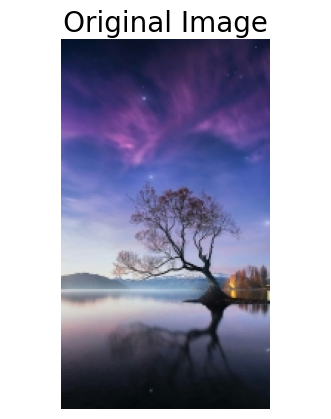

In [106]:
# bug_img = plt.imread('bug_4.jpg')
# bridge = plt.imread('bridge.jpg')
# ridge = plt.imread('ridge.jpg')
# sunflower = plt.imread('sunflower.jpg')
# street = plt.imread('street.jpg')
scene = plt.imread(r'Project\IMAGES\scene.jpg')

import os

# img_list = [bug_img, bridge, ridge, sunflower, street, scene]
img_list = [scene]
# for file in os.listdir('imagenet'):
#     img = plt.imread('imagenet/' + file)
#     # print(file)
#     img_list.append(img)

for img in img_list:
    plt.title('      Original Image      ', fontsize=20)
    plt.axis('off')
    plt.imshow(img)
    plt.savefig('Project/IMAGES/original_img/scene.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    # plt.imshow(img, cmap='gray', vmax=255, vmin=0)
    # plt.title('Original Image', fontsize=20)
    # plt.axis('off')
    # plt.tight_layout()
    # # plt.imshow(img)
    # # plt.show()
    # # plt.close()
    # plt.savefig('Project/IMAGES/original_img/scene.jpg', bbox_inches='tight', pad_inches=0)
    # # plt.imsave('Project/IMAGES/original_img/scene.png', img)
    # plt.show()
    # imgseg.histogram(img)
    # for num_cluster in range(2, 15):
    #     imgseg = ImageSegmentation(num_cluster)
    #     imgseg.fit(img)
    #     seg_img = imgseg.get_segmented_image()
    #     plt.imshow(seg_img, cmap='gray', vmax=255, vmin=0)
    #     plt.axis('off')
    #     plt.title('Number of Clusters: ' + str(num_cluster), fontsize=20)
        
    #     # plt.imsave('IMAGES/clustered/scene_' + str(num_cluster) + '.png', seg_img, cmap='gray', vmax=255, vmin=0)
    #     # plt.savefig('IMAGES/clustered/scene_' + str(num_cluster) + '.png', bbox_inches='tight', pad_inches=0)
    #     plt.show()
    #     plt.close()
    #     # imgseg.histogram(seg_img, return_hist=True)
    #     # imgseg.histogram(img)
    

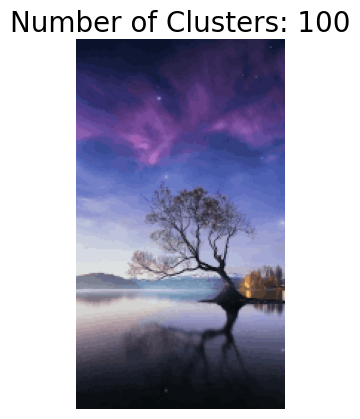

In [85]:
sunflower_img = plt.imread(r'Project\IMAGES\scene.jpg')

# cluster the image and show the segmented image

num_clusters = [100]

for num_cluster in num_clusters:#range(20, 21):
    imgseg = ImageSegmentation(num_cluster)
    imgseg.fit(sunflower_img)
    seg_img = imgseg.get_segmented_image()
    plt.tight_layout()
    plt.title('Number of Clusters: ' + str(num_cluster), fontsize=20)
    plt.imshow(seg_img, cmap='gray', vmax=255, vmin=0)
    plt.axis('off')
    
    # tight layout
    # plt.imsave('Project/IMAGES/clustered/bridge_' + str(num_cluster) + '.png', seg_img, cmap='gray', vmax=255, vmin=0)
    # plt.savefig('tmp_img' + str(num_cluster) + '.jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    # imgseg.histogram(seg_img, return_hist=True)
    # imgseg.histogram(img)

torch.return_types.topk(
values=tensor([[0.6274, 0.4321, 0.4203, 0.3978, 0.3588]], grad_fn=<TopkBackward0>),
indices=tensor([[772, 750, 539, 477, 195]]))
torch.return_types.topk(
values=tensor([[0.6274]], grad_fn=<TopkBackward0>),
indices=tensor([[772]]))


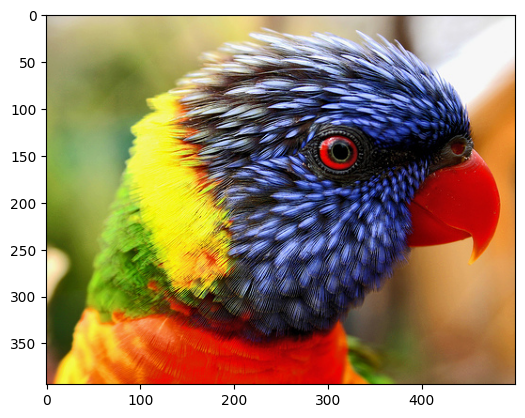

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
# import 

# download resnet18
resnet18 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

# open image Project\imagenet\n01820546_214.JPEG
img = plt.imread('Project/imagenet/n01820546_214.JPEG')

plt.imshow(img)

# Apply resnet transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# transform image
img = transform(img)

# add batch dimension
img = img.unsqueeze(0)

# get prediction
pred = resnet18(img)

# get top 5 predictions
top5 = torch.topk(pred, 5)
print(top5)
# print top 5 labels
# print(top5_labels)

# get top 1 prediction
top1 = torch.topk(pred, 1)
print(top1)

# get top 1 label
# top1_label = torchvision.models.resnet18.idx_to_labels[top1.indices[0][0]]

# print top 1 label
# print(top1_label)


Time:  0.13421201705932617
Predicted class:  21


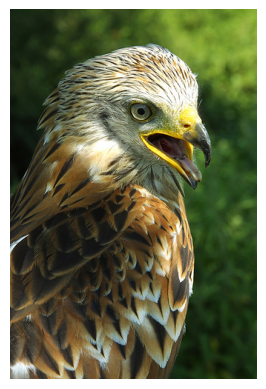

In [59]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import time

# Load the pre-trained ResNet-50 model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.eval()  # Set the model to evaluation mode

# Load and preprocess the test image
image_path = r"Project\imagenet\n01608432_838.JPEG"  # Replace with the path to your test image
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension

# Make predictions

start_time = time.time()

with torch.no_grad():
    output = model(image)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # print the max probability and the corresponding index
    # print("Max probability: ", torch.max(probabilities).item())
    # print("Index: ", torch.argmax(probabilities).item())
    
    predicted_class = torch.argmax(probabilities, dim=1).item()

print("Time: ", time.time() - start_time)

# Print predicted class label
print("Predicted class: ", predicted_class)

# Show the test image
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()


Time:  0.12796401977539062
Predicted class:  21


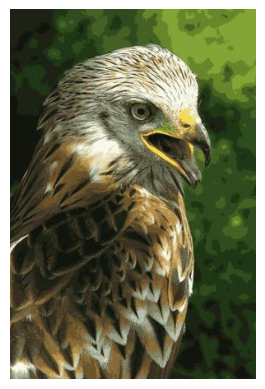

In [66]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained ResNet-50 model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.eval()  # Set the model to evaluation mode

# Load and preprocess the test image
image_path = "tmp_img20.jpg"  # Replace with the path to your test image
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension


start_time = time.time()

# Make predictions
with torch.no_grad():
    output = model(image)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # print the max probability and the corresponding index
    # print("Max probability: ", torch.max(probabilities).item())
    # print("Index: ", torch.argmax(probabilities).item())
    
    predicted_class = torch.argmax(probabilities, dim=1).item()

print("Time: ", time.time() - start_time)

# Print predicted class label
print("Predicted class: ", predicted_class)

# Show the test image
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()
